# data preparation and baseline model

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [2]:
X_train = pd.read_csv('data/Training_set_values.csv', index_col='id')
X_test = pd.read_csv('data/Test_set_values.csv', index_col='id')
y_train = pd.read_csv('data/Training_set_labels.csv', index_col='id')

In [3]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
y_train.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


### merging the X and y train data

In [5]:
df = X_train.merge(y_train, on='id')

we merged the X train and y train data to build a dataframe that we could use to testing our different models on. The data set from where the data came did not have a y test dataset. we will split the merged dataset and create a hold out group later.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

**note:** our initial dataset included 40 features

### data exploration and cleaning

In [7]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [8]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**note:** the target variable (status_group) is imbalanced
>approximately 54% 'functional', 38% 'non functional', and 7% 'functional needs repair'

### dropping some features we determined that we don't need based on what we've gathered from exploring our data

In [9]:
cols_to_drop = ['amount_tsh',
                'scheme_name', 
                'date_recorded', 
                'wpt_name', 
                'subvillage', 
                'lga', 
                'ward', 
                'recorded_by', 
                'quantity_group',
                'quality_group',
                'payment_type', 
                'funder', 
                'extraction_type_group', 
                'extraction_type_class',
                'management_group',
                'source_type',
                'source_class',
                'waterpoint_type_group'
]
df = df.drop(cols_to_drop, axis = 1)
df = df.fillna('missing', axis = 1)

**note:** 

with so many unique values for some features, onehotencoding creates more than 60,000 columns (out of a dataframe with 59,400 entries), making our models computationally prohibitive.  

we examined each feature based on the descriptions provided on the competitions website (url provided below).

>**competition website:** https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#labels_list

we noticed that several features were duplicative so we decided to drop them from our dataset. below is a list of columns that were dropped and our reasoning for excluding them:

* `amount_tsh` - total static head (amount water available to waterpoint)               **DROP:**  Dataset is missing a majority of values for this feature <br>
* `date_recorded` - the date the row was entered                                        **DROP:** <br>
* `funder` - who funded the well                                                        **DROP:** <br>
* `wpt_name` - name of the waterpoint if there is one                                   **DROP:** <br>
* `subvillage` - geographic location                                                    **DROP:** <br>
* `lga` - geographic location                                                           **DROP:** <br>
* `ward` - geographic location                                                          **DROP:** <br>
* `recorded_by` - group entering this row of data                                       **DROP:** <br>
* `scheme_name` - who operates the waterpoint                                           **DROP:** this feature is duplicative <br>
* `extraction_type_group` - the kind of extraction the waterpoint uses                  **DROP:** <br>
* `extraction_type_class` - the kind of extraction the waterpoint uses                  **DROP:** <br>
* `management_group` - how the waterpoint is managed                                    **DROP:** <br>
* `payment_type` - what the water costs                                                 **DROP:** <br>
* `quality_group` - the quality of the water                                            **DROP:** <br>
* `quantity_group` - the quantity of water                                              **DROP:** <br>
* `source_type` - the source of the water                                               **DROP:** <br>
* `source_class` - the source of the water                                              **DROP:** <br>
* `waterpoint_type_group` - The kind of waterpoint                                      **DROP:** <br>

additionally, we replaced NaN values with 'missing' to keep the rows in our dataframe. we will onehotencode the dataframe later.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         59400 non-null  int64  
 1   installer          59400 non-null  object 
 2   longitude          59400 non-null  float64
 3   latitude           59400 non-null  float64
 4   num_private        59400 non-null  int64  
 5   basin              59400 non-null  object 
 6   region             59400 non-null  object 
 7   region_code        59400 non-null  int64  
 8   district_code      59400 non-null  int64  
 9   population         59400 non-null  int64  
 10  public_meeting     59400 non-null  object 
 11  scheme_management  59400 non-null  object 
 12  permit             59400 non-null  object 
 13  construction_year  59400 non-null  int64  
 14  extraction_type    59400 non-null  object 
 15  management         59400 non-null  object 
 16  payment           

**note:**

our dataset is now left with 22 features.

In [11]:
df['installer'].replace(to_replace='0', value='missing', inplace=True)
df['installer'].replace('Gover', 'Government', inplace=True)
df['installer'].replace('Commu', 'Community')
df['installer'].replace('District council', 'District Council', inplace=True)

toptwenty_installers = list(df.installer.value_counts()[:21].index)
toptwenty_installers.remove('missing')
df.installer = df.installer.apply(lambda x: x if x in toptwenty_installers else 'other')

### creating a holdout set and running a train_test_split

the holdout set will be used for additional testing of our final model.

In [12]:
df, holdout = train_test_split(df, test_size = .1, random_state=42)

In [13]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [14]:
X_train.to_csv('data/X_train.csv')
X_test.to_csv('data/X_test.csv')
y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')
df.to_csv('data/holdout_data.csv')

# baseline dummy model

In [15]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [16]:
print('Accuracy Score Train:', dummy_model.score(X_train, y_train))
print('Accuracy Score Test:', dummy_model.score(X_test, y_test))

Accuracy Score Train: 0.5436089287941139
Accuracy Score Test: 0.543658810325477


In [17]:
log_loss_dummy = cross_val_score(dummy_model, X_train, y_train, scoring='neg_log_loss')
log_loss_dummy = -log_loss_dummy.mean()
print('Log Loss:', log_loss_dummy)

Log Loss: 15.763189157013858


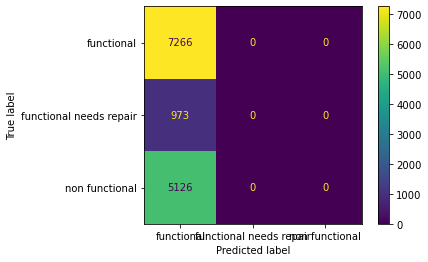

In [18]:
plot_confusion_matrix(dummy_model, X_test, y_test);

In [19]:
y_pred = dummy_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

The model correctly predicts 100.0% of the funtional wells.
The model correctly predicts 0.0% of the funtional-needs-repair wells.
The model correctly predicts 0.0% of the non-functional wells.


**note:**

as expected, the dummy model predicts 'functional' all the time.  this produces an overall accuracy score on the test data of 54.4%. 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 31080 to 23812
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         53460 non-null  int64  
 1   installer          53460 non-null  object 
 2   longitude          53460 non-null  float64
 3   latitude           53460 non-null  float64
 4   num_private        53460 non-null  int64  
 5   basin              53460 non-null  object 
 6   region             53460 non-null  object 
 7   region_code        53460 non-null  int64  
 8   district_code      53460 non-null  int64  
 9   population         53460 non-null  int64  
 10  public_meeting     53460 non-null  object 
 11  scheme_management  53460 non-null  object 
 12  permit             53460 non-null  object 
 13  construction_year  53460 non-null  int64  
 14  extraction_type    53460 non-null  object 
 15  management         53460 non-null  object 
 16  payment           